<a target="_blank" href="https://colab.research.google.com/github/cohere-ai/notebooks/blob/main/notebooks/llmu/RAG_with_Chat_Embed_and_Rerank.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# RAG with Chat, Embed, and Rerank

This notebook shows how to build a RAG-powered chatbot with Cohere's Chat endpoint.  The chatbot can extract relevant information from external documents and produce verifiable, inline citations in its responses.

Read the accompanying [article here](https://txt.cohere.com/rag-chatbot/).

This application will use several Cohere API endpoints:

- Chat: For handling the main logic of the chatbot, including turning a user message into queries, generating responses, and producing citations
- Embed: For turning textual documents into their embeddings representation, later to be used in retrieval (we’ll use the latest, state-of-the-art Embed v3 model)
- Rerank: For reranking the retrieved documents according to their relevance to a query

The diagram below provides an overview of what we’ll build.

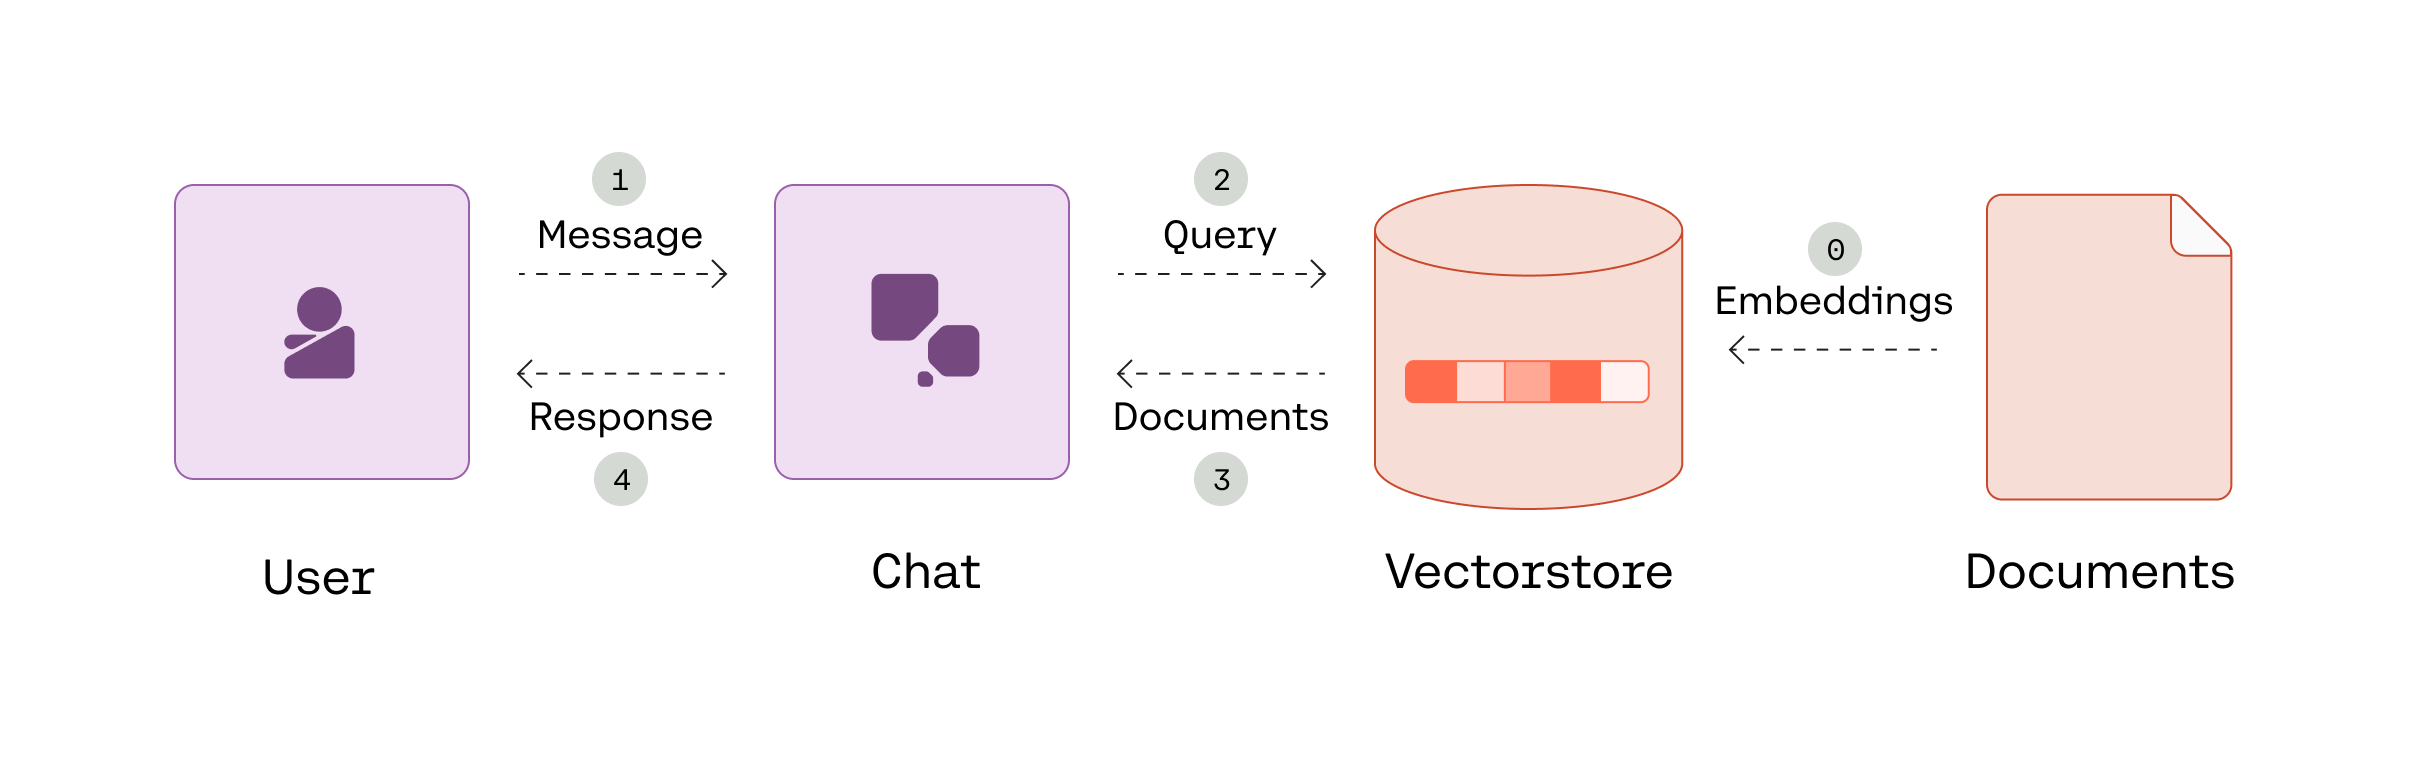

Here is a summary of the steps involved.

Initial phase:
- **Step 0**: Ingest the documents – get documents, chunk, embed, and index.

For each user-chatbot interaction:
- **Step 1**: Get the user message
- **Step 2**: Call the Chat endpoint in query-generation mode
- If at least one query is generated
  - **Step 3**: Retrieve and rerank relevant documents
  - **Step 4**: Call the Chat endpoint in document mode to generate a grounded response with citations
- If no query is generated
  - **Step 4**: Call the Chat endpoint in normal mode to generate a response

# Setup

In [ ]:
! pip install cohere hnswlib unstructured -q

In [ ]:
import cohere
import uuid
import hnswlib
from typing import List, Dict
from unstructured.partition.html import partition_html
from unstructured.chunking.title import chunk_by_title

co = cohere.Client("COHERE_API_KEY") # Get your API key here: https://dashboard.cohere.com/api-keys

In [ ]:
#@title Enable text wrapping in Google Colab

from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

# Create a vector store for ingestion and retrieval


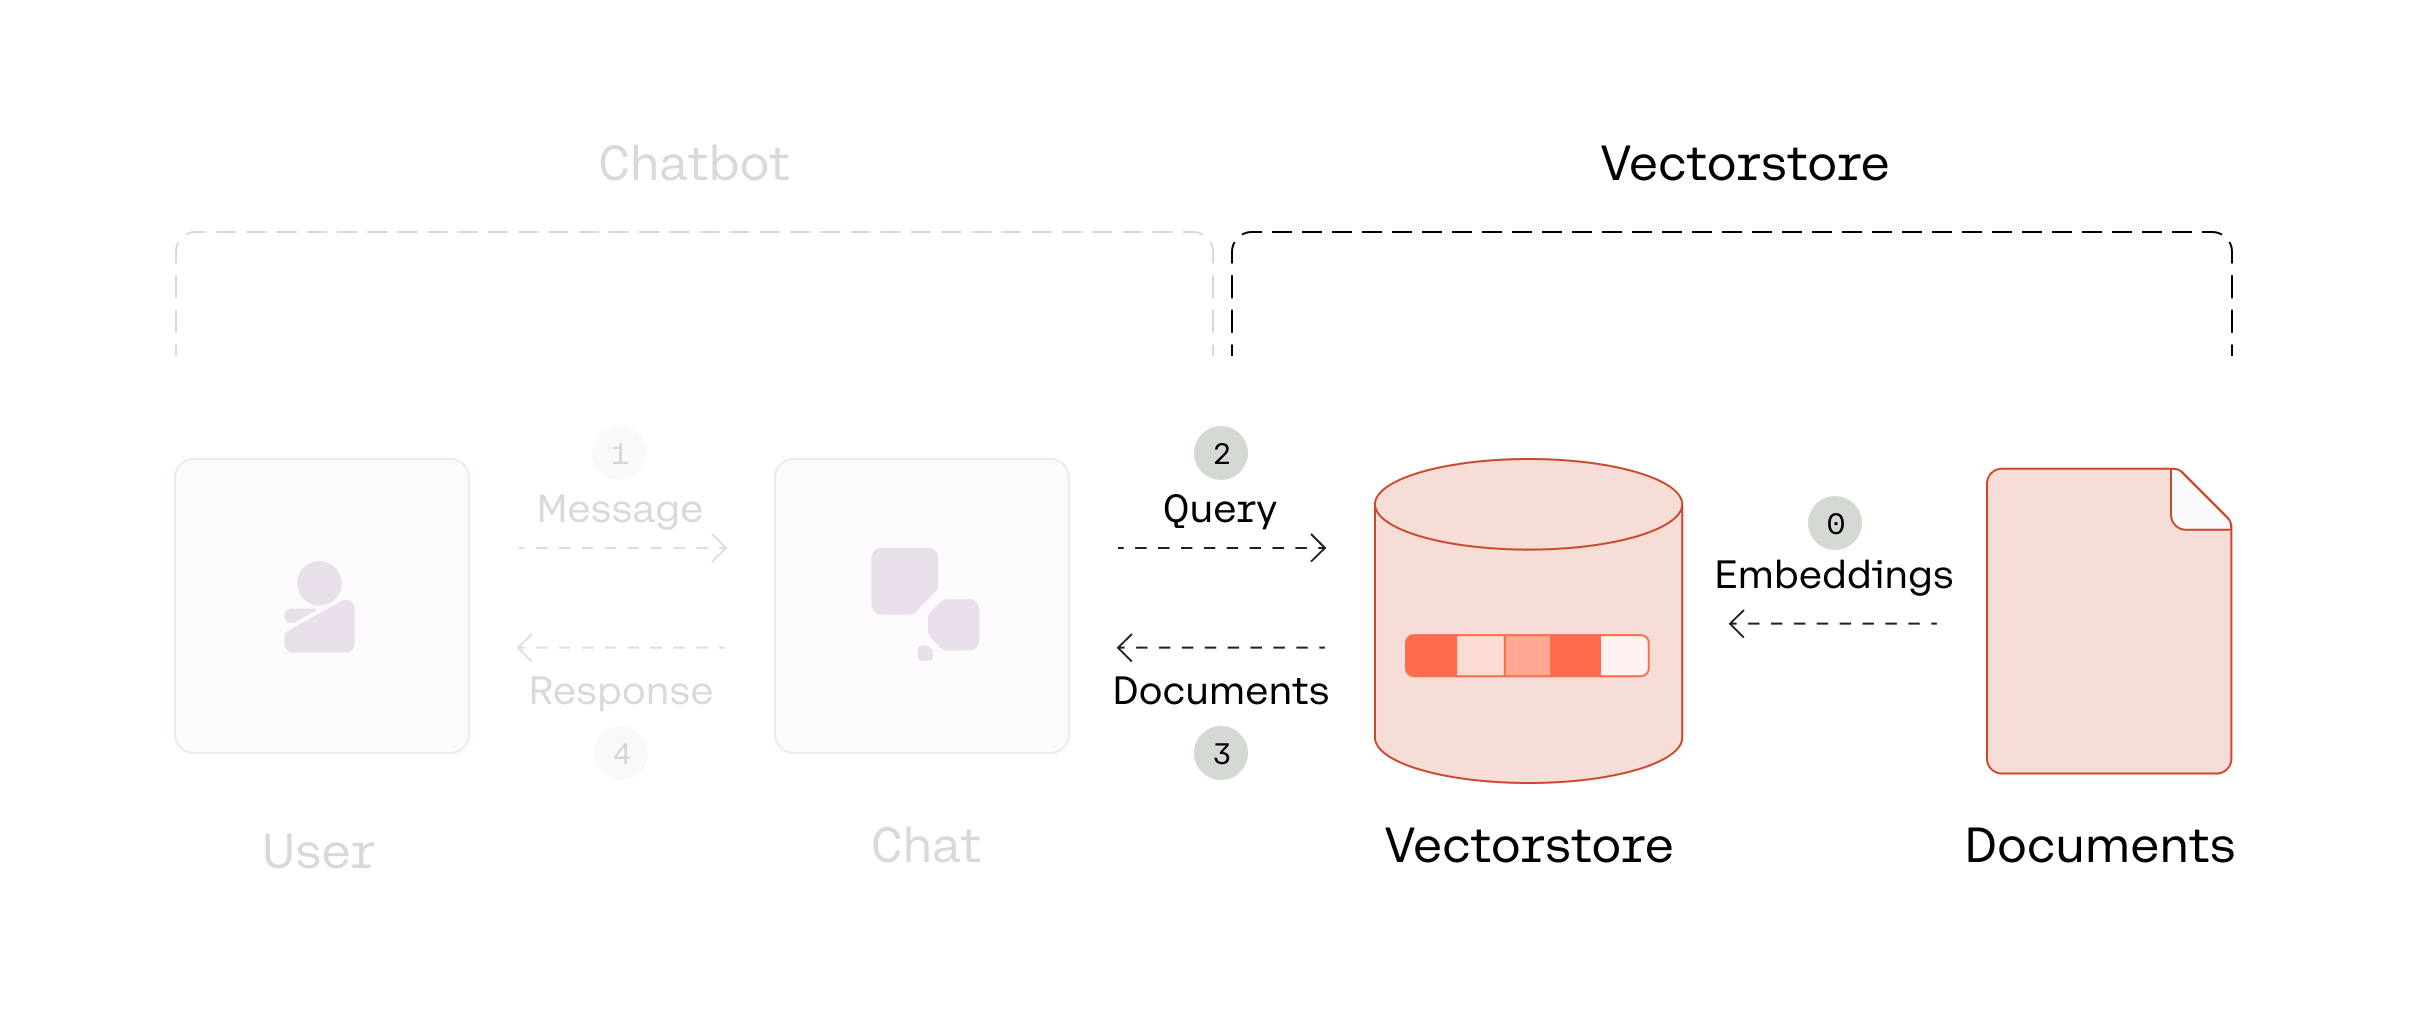


First, we define the list of documents we want to ingest and make available for retrieval. As an example, we'll use the contents from the first module of Cohere's *LLM University: What are Large Language Models?*.

In [ ]:
raw_documents = [
    {
        "title": "Text Embeddings",
        "url": "https://docs.cohere.com/docs/text-embeddings"},
    {
        "title": "Similarity Between Words and Sentences",
        "url": "https://docs.cohere.com/docs/similarity-between-words-and-sentences"},
    {
        "title": "The Attention Mechanism",
        "url": "https://docs.cohere.com/docs/the-attention-mechanism"},
    {
        "title": "Transformer Models",
        "url": "https://docs.cohere.com/docs/transformer-models"}
]

Usually the number of documents for practical applications is vast, and so we'll need to be able to search documents efficiently.  This involves breaking the documents into chunks, generating embeddings, and indexing the embeddings, as shown in the image below.  

We implement this in the `Vectorstore` class below, which takes the `raw_documents` list as input.  Three methods are immediately called when creating an object of the `Vectorstore` class:


`load_and_chunk()`  
This method uses the `partition_html()` method from the `unstructured` library to load the documents from URL and break them into smaller chunks.  Each chunk is turned into a dictionary object with three fields:
- `title` - the web page’s title,
- `text` - the textual content of the chunk, and
- `url` - the web page’s URL.  
  
  
`embed()`  
This method uses Cohere's `embed-english-v3.0` model to generate embeddings of the chunked documents.  Since our documents will be used for retrieval, we set `input_type="search_document"`.  We send the documents to the Embed endpoint in batches, because the endpoint has a limit of 96 documents per call.

`index()`  
This method uses the `hsnwlib` package to index the document chunk embeddings.  This will ensure efficient similarity search during retrieval.  Note that `hnswlib` uses a vector library, and we have chosen it for its simplicity.

In [ ]:
class Vectorstore:
    """
    A class representing a collection of documents indexed into a vectorstore.

    Parameters:
    raw_documents (list): A list of dictionaries representing the sources of the raw documents. Each dictionary should have 'title' and 'url' keys.

    Attributes:
    raw_documents (list): A list of dictionaries representing the raw documents.
    docs (list): A list of dictionaries representing the chunked documents, with 'title', 'text', and 'url' keys.
    docs_embs (list): A list of the associated embeddings for the document chunks.
    docs_len (int): The number of document chunks in the collection.
    idx (hnswlib.Index): The index used for document retrieval.

    Methods:
    load_and_chunk(): Loads the data from the sources and partitions the HTML content into chunks.
    embed(): Embeds the document chunks using the Cohere API.
    index(): Indexes the document chunks for efficient retrieval.
    retrieve(): Retrieves document chunks based on the given query.
    """

    def __init__(self, raw_documents: List[Dict[str, str]]):
        self.raw_documents = raw_documents
        self.docs = []
        self.docs_embs = []
        self.retrieve_top_k = 10
        self.rerank_top_k = 3
        self.load_and_chunk()
        self.embed()
        self.index()


    def load_and_chunk(self) -> None:
        """
        Loads the text from the sources and chunks the HTML content.
        """
        print("Loading documents...")

        for raw_document in self.raw_documents:
            elements = partition_html(url=raw_document["url"])
            chunks = chunk_by_title(elements)
            for chunk in chunks:
                self.docs.append(
                    {
                        "title": raw_document["title"],
                        "text": str(chunk),
                        "url": raw_document["url"],
                    }
                )

    def embed(self) -> None:
        """
        Embeds the document chunks using the Cohere API.
        """
        print("Embedding document chunks...")

        batch_size = 90
        self.docs_len = len(self.docs)
        for i in range(0, self.docs_len, batch_size):
            batch = self.docs[i : min(i + batch_size, self.docs_len)]
            texts = [item["text"] for item in batch]
            docs_embs_batch = co.embed(
                texts=texts, model="embed-english-v3.0", input_type="search_document"
            ).embeddings
            self.docs_embs.extend(docs_embs_batch)

    def index(self) -> None:
        """
        Indexes the document chunks for efficient retrieval.
        """
        print("Indexing document chunks...")

        self.idx = hnswlib.Index(space="ip", dim=1024)
        self.idx.init_index(max_elements=self.docs_len, ef_construction=512, M=64)
        self.idx.add_items(self.docs_embs, list(range(len(self.docs_embs))))

        print(f"Indexing complete with {self.idx.get_current_count()} document chunks.")

    def retrieve(self, query: str) -> List[Dict[str, str]]:
        """
        Retrieves document chunks based on the given query.

        Parameters:
        query (str): The query to retrieve document chunks for.

        Returns:
        List[Dict[str, str]]: A list of dictionaries representing the retrieved document chunks, with 'title', 'text', and 'url' keys.
        """

        # Dense retrieval
        query_emb = co.embed(
            texts=[query], model="embed-english-v3.0", input_type="search_query"
        ).embeddings

        doc_ids = self.idx.knn_query(query_emb, k=self.retrieve_top_k)[0][0]

        # Reranking
        docs_to_rerank = [self.docs[doc_id]["text"] for doc_id in doc_ids]

        rerank_results = co.rerank(
            query=query,
            documents=docs_to_rerank,
            top_n=self.rerank_top_k,
            model="rerank-english-v2.0",
        )

        doc_ids_reranked = [doc_ids[result.index] for result in rerank_results.results]

        docs_retrieved = []
        for doc_id in doc_ids_reranked:
            docs_retrieved.append(
                {
                    "title": self.docs[doc_id]["title"],
                    "text": self.docs[doc_id]["text"],
                    "url": self.docs[doc_id]["url"],
                }
            )

        return docs_retrieved

In the code cell below, we initialize an instance of the `Vectorstore` class and pass in the `raw_documents` list as input.

In [ ]:
# Create an instance of the Vectorstore class with the given sources
vectorstore = Vectorstore(raw_documents)

Loading documents...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Embedding document chunks...
Indexing document chunks...
Indexing complete with 136 document chunks.


The `Vectorstore` class also has a `retrieve()` method, which we'll use to retrieve relevant document chunks given a query (as in Step 3 in the diagram shared at the beginning of this notebook).  This method has two components: (1) dense retrieval, and (2) reranking.

### Dense retrieval

First, we embed the query using the same `embed-english-v3.0` model we used to embed the document chunks, but this time we set `input_type="search_query"`.

Search is performed by the `knn_query()` method from the `hnswlib` library. Given a query, it returns the document chunks most similar to the query. We can define the number of document chunks to return using the attribute `self.retrieve_top_k=10`.

### Reranking

After semantic search, we implement a reranking step.  While our semantic search component is already highly capable of retrieving relevant sources, the [Rerank endpoint](https://cohere.com/rerank) provides an additional boost to the quality of the search results, especially for complex and domain-specific queries. It takes the search results and sorts them according to their relevance to the query.

We call the Rerank endpoint with the `co.rerank()` method and define the number of top reranked document chunks to retrieve using the attribute `self.rerank_top_k=3`.  The model we use is `rerank-english-v2.0`.  

This method returns the top retrieved document chunks `chunks_retrieved` so that they can be passed to the chatbot.

In the code cell below, we check the document chunks that are retrieved for the query `"multi-head attention definition"`.

## Test Retrieval

In [ ]:
vectorstore.retrieve("multi-head attention definition")

[{'title': 'Transformer Models',
  'text': 'The attention step used in transformer models is actually much more powerful, and it’s called multi-head attention. In multi-head attention, several different embeddings are used to modify the vectors and add context to them. Multi-head attention has helped language models reach much higher levels of efficacy when processing and generating text.',
  'url': 'https://docs.cohere.com/docs/transformer-models'},
 {'title': 'The Attention Mechanism',
  'text': "What you learned in this chapter is simple self-attention. However, we can do much better than that. There is a method called multi-head attention, in which one doesn't only consider one embedding, but several different ones. These are all obtained from the original by transforming it in different ways. Multi-head attention has been very successful at the task of adding context to text. If you'd like to learn more about the self and multi-head attention, you can check out the following two",

# Create a chatbot

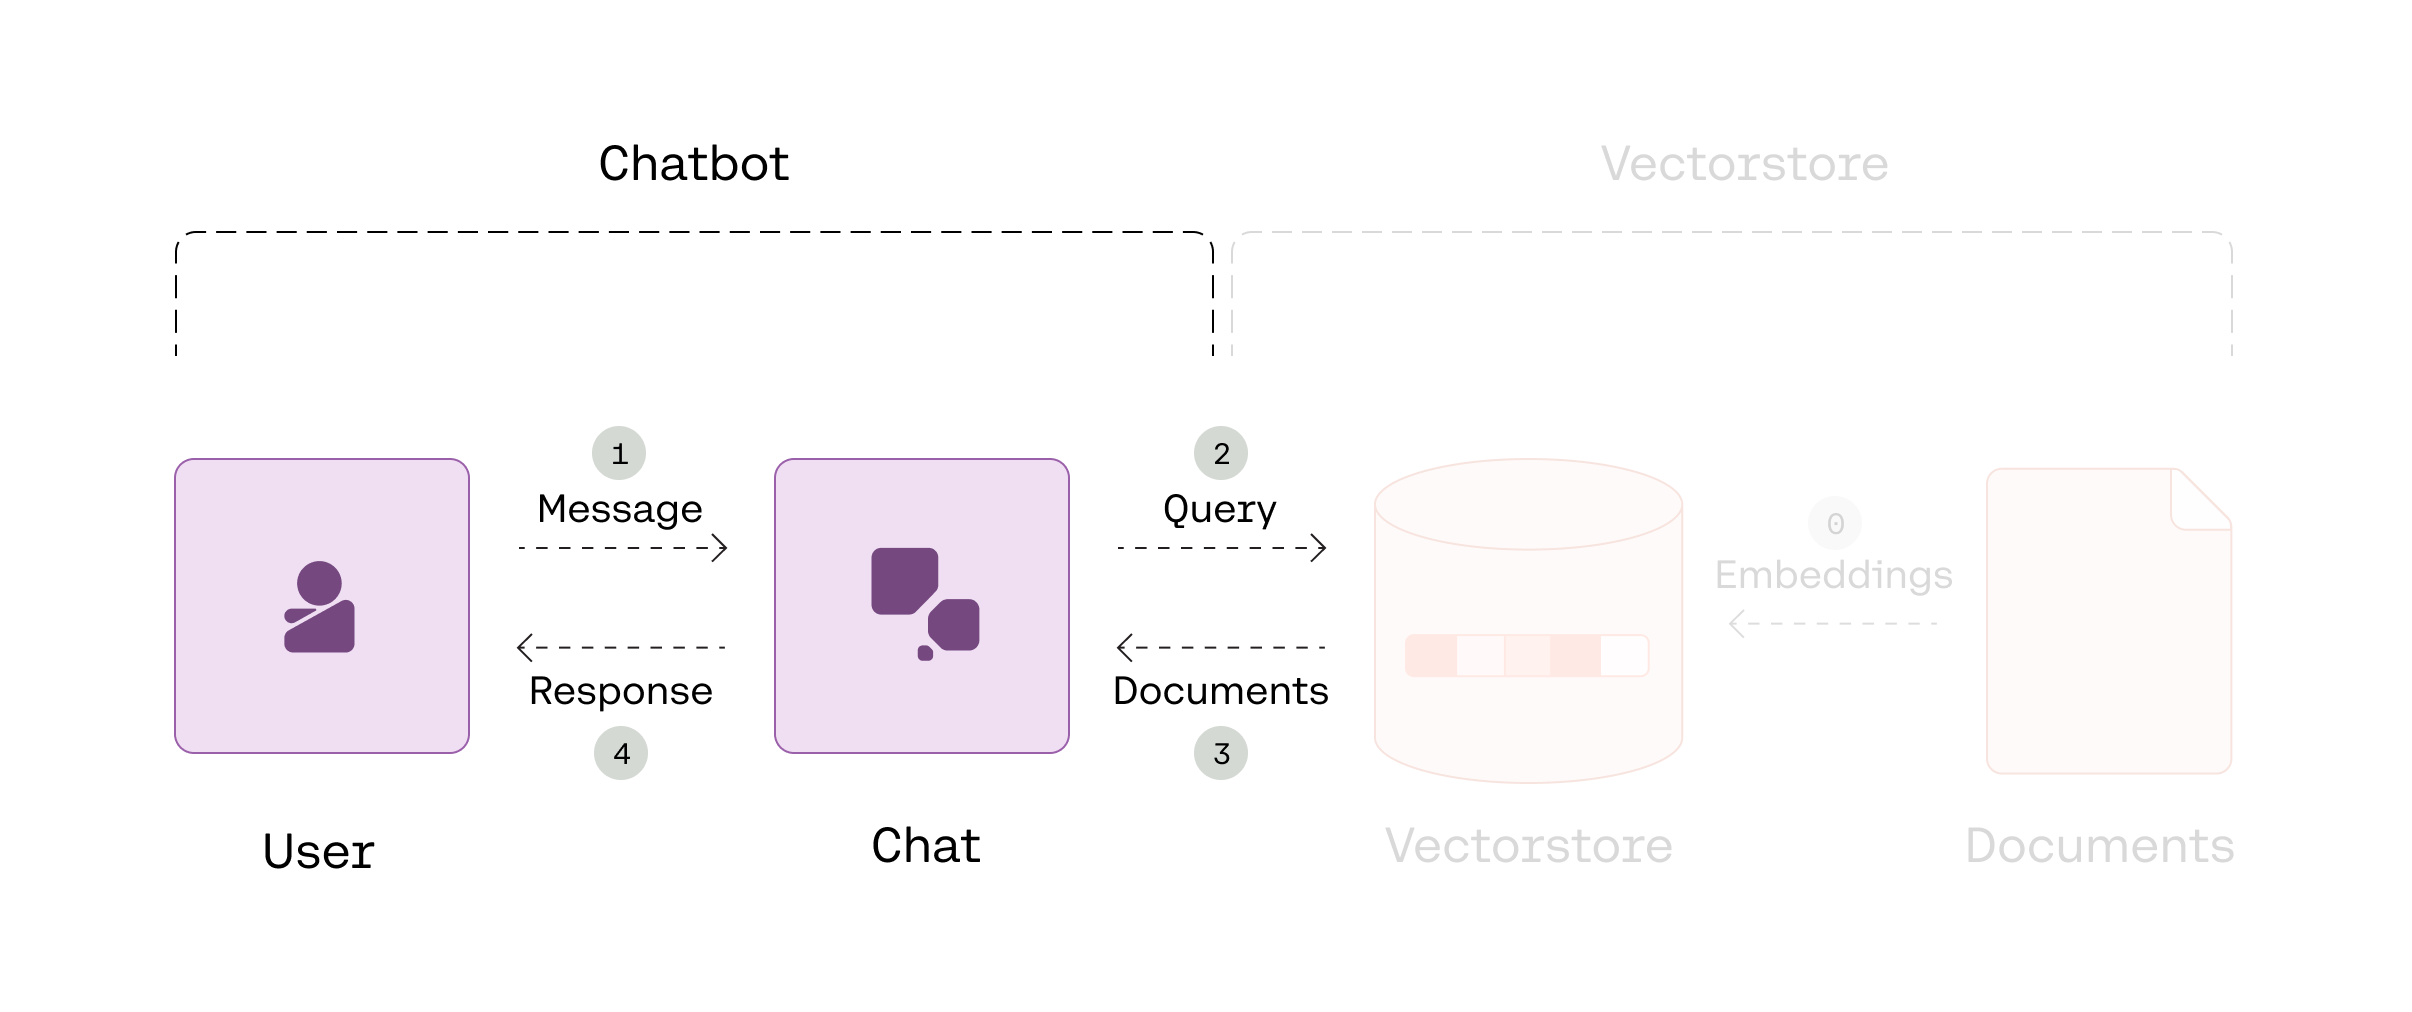


Next, we implement a class to handle the interaction between the user and the chatbot.  It takes an instance of the `Vectorstore` class as input.

The `run()` method will be used to run the chatbot application.  It begins with the logic for getting the user message, along with a way for the user to end the conversation.  

Based on the user message, the chatbot needs to decide if it needs to consult external information before responding.  If so, the chatbot determines an optimal set of search queries to use for retrieval.  When we call `co.chat()` with `search_queries_only=True`, the Chat endpoint handles this for us automatically.

The generated queries can be accessed from the `search_queries` field of the object that is returned.  Then, what happens next depends on how many queries are returned.
- If queries are returned, we call the `retrieve()` method of the Vectorstore object for the  retrieval step.  The retrieved document chunks are then passed to the Chat endpoint by adding a `documents` parameter when we call `co.chat()` again.
- Otherwise, if no queries are returned, we call the Chat endpoint another time, passing the user message and without needing to add any documents to the call.

In either case, we also pass the `conversation_id` parameter, which retains the interactions between the user and the chatbot in the same conversation thread. We also enable the `stream` parameter so we can stream the chatbot response.

We then print the chatbot's response.  In the case that the external information was used to generate a response, we also display citations.

In [ ]:
class Chatbot:
    def __init__(self, vectorstore: Vectorstore):
        """
        Initializes an instance of the Chatbot class.

        Parameters:
        vectorstore (Vectorstore): An instance of the Vectorstore class.

        """
        self.vectorstore = vectorstore
        self.conversation_id = str(uuid.uuid4())

    def run(self):
        """
        Runs the chatbot application.

        """
        while True:
            # Get the user message
            message = input("User: ")

            # Typing "quit" ends the conversation
            if message.lower() == "quit":
              print("Ending chat.")
              break
            # else:                       # Uncomment for Google Colab to avoid printing the same thing twice
              # print(f"User: {message}") # Uncomment for Google Colab to avoid printing the same thing twice

            # Generate search queries (if any)
            response = co.chat(message=message,
                               model="command-r",
                               search_queries_only=True)

            # If there are search queries, retrieve document chunks and respond
            if response.search_queries:
                print("Retrieving information...", end="")

                # Retrieve document chunks for each query
                documents = []
                for query in response.search_queries:
                    documents.extend(self.vectorstore.retrieve(query.text))

                # Use document chunks to respond
                response = co.chat_stream(
                    message=message,
                    model="command-r",
                    documents=documents,
                    conversation_id=self.conversation_id,
                )

            # If there is no search query, directly respond
            else:
                response = co.chat_stream(
                    message=message,
                    model="command-r",
                    conversation_id=self.conversation_id,
                )

            # Print the chatbot response, citations, and documents
            print("\nChatbot:")
            citations = []
            cited_documents = []

            # Display response
            for event in response:
                if event.event_type == "text-generation":
                    print(event.text, end="")
                elif event.event_type == "citation-generation":
                    citations.extend(event.citations)
                elif event.event_type == "search-results":
                    cited_documents = event.documents

            # Display citations and source documents
            if citations:
              print("\n\nCITATIONS:")
              for citation in citations:
                print(citation)

              print("\nDOCUMENTS:")
              for document in cited_documents:
                print(document)

            print(f"\n{'-'*100}\n")

# Run the chatbot

We can now run the chatbot.  For this, we create the instance of `Chatbot` and run the chatbot by invoking the `run()` method.

The format of each citation is:
- `start`: The starting point of a span where one or more documents are referenced
- `end`: The ending point of a span where one or more documents are referenced
- `text`: The text representing this span
- `document_ids`: The IDs of the documents being referenced (`doc_0` being the ID of the first document passed to the `documents` creating parameter in the endpoint call, and so on)

In [ ]:
# Create an instance of the Chatbot class
chatbot = Chatbot(vectorstore)

# Run the chatbot
chatbot.run()

User: Hello, I have a question

Chatbot:
Hello! What's your question? I'm here to help you in any way I can.
----------------------------------------------------------------------------------------------------

User: What’s the difference between word and sentence embeddings
Retrieving information...
Chatbot:
Word embeddings associate words with lists of numbers. Similar words are assigned numbers that are mathematically close while dissimilar words are assigned numbers that are far apart. 

Sentence embeddings do the same thing as word embeddings, but for sentences. Each sentence is associated with a vector of numbers in a coherent way. This means that similar sentences are assigned similar vectors and dissimilar sentences are assigned different vectors.

CITATIONS:
start=0 end=15 text='Word embeddings' document_ids=['doc_0']
start=16 end=54 text='associate words with lists of numbers.' document_ids=['doc_0']
start=55 end=68 text='Similar words' document_ids=['doc_0']
start=82 end=119

In the conversation above, notice a few observations that reflect the different components of what we built:

- **Direct response**: For user messages that don’t require retrieval, such as "Hello, I have a question", the chatbot responds directly without requiring retrieval.
- **Citation generation**: For responses that do require retrieval ("What’s the difference between word and sentence embeddings"), the endpoint returns the response together with the citations.
- **State management**: The endpoint maintains the state of the conversation via the `conversation_id` parameter, for example, by being able to correctly respond to a vague user message of "And what are their similarities".
- **Response synthesis**: The model can decide if none of the retrieved documents provide the necessary information required to answer a user message. For example, when asked the question "What do you know about 5G networks", the chatbot goes on and retrieves external information from the index. However, it doesn’t use any of the information in its response as none of them is relevant to the question.